# Circuit Detection Evaluation
Simple evaluation of ML detector against labeled ground truth

In [2]:
# Imports
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from traffic.core import Flight
from lommis_func import find_aerodrome_circuits, detect_runway
from traffic.data import airports
from sklearn.model_selection import train_test_split

In [3]:
# Load ALL labeled data (including omitted)
df_full = pd.read_parquet('EMERGENCY_SAVE.parquet')
print(f"Loaded {len(df_full)} total segments from EMERGENCY_SAVE.parquet")
print(f"\nFull label distribution:")
print(df_full['label'].value_counts())

# ============================================================
# STEP 1: Filter out flights that have ANY omitted segments
# ============================================================
print("\n" + "="*60)
print("STEP 1: Filtering out flights with ANY omitted segments")
print("="*60)

# Get all unique flights that have at least one omitted segment
flights_with_omitted = df_full[df_full['label'] == 'omitted']['unique_flight_id'].unique()
print(f"Found {len(flights_with_omitted)} flights with omitted segments")

# Get all unique flights in the dataset
all_flights = df_full['unique_flight_id'].unique()
print(f"Total unique flights: {len(all_flights)}")

# Filter out flights with omitted segments
valid_flights = set(all_flights) - set(flights_with_omitted)
print(f"Valid flights (no omitted segments): {len(valid_flights)}")
print(f"Excluded flights: {len(flights_with_omitted)}")

# Keep only segments from valid flights
df_labeled = df_full[df_full['unique_flight_id'].isin(valid_flights)].reset_index(drop=True)

# Now filter out omitted labels (these are leftovers from the filtering)
df_labeled = df_labeled[df_labeled['label'].isin(['traffic_circuit', 'not_a_circuit'])].reset_index(drop=True)

print(f"\nFinal labeled segments: {len(df_labeled)}")

# ============================================================
# STEP 2: Recreate the same train/test split as training.ipynb
# (This ensures we use the EXACT same test set the model was trained on)
# ============================================================
print("\n" + "="*60)
print("STEP 2: Recreating train/test split (same as training notebook)")
print("="*60)

# Use SAME random_state=42 as training.ipynb
_, df_temp = train_test_split(df_labeled, test_size=0.3, random_state=42, stratify=df_labeled['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

print(f"Train set: {len(df_labeled) - len(df_temp)} segments")
print(f"Val set: {len(df_val)} segments")
print(f"Test set: {len(df_test)} segments")
print(f"\nTest set label distribution:")
print(df_test['label'].value_counts())

# ============================================================
# STEP 3: Build flight lookup from test set ONLY
# ============================================================
print("\n" + "="*60)
print("STEP 3: Building flight lookup (test set only)")
print("="*60)

flight_lookup = {}
for flight_id, group in df_test.groupby('unique_flight_id'):
    col = group['flight_pickle'].dropna()
    if col.empty:
        print(f"Warning: Flight {flight_id} has no flight_pickle; skipping")
        continue
    fp = col.iloc[0]
    try:
        flight_lookup[flight_id] = pickle.loads(fp)
    except Exception as e:
        print(f"Failed to unpickle {flight_id}: {e}")

print(f"Successfully loaded {len(flight_lookup)} flights from test set")

# ============================================================
# STEP 4: For test flights, get ALL segments (not just test segments)
# This ensures complete ground truth for each test flight
# ============================================================
print("\n" + "="*60)
print("STEP 4: Computing ground truth from ALL segments of test flights")
print("="*60)

# Get the list of test flight IDs (331 flights)
test_flight_ids = list(flight_lookup.keys())
print(f"Found {len(test_flight_ids)} unique flights in test set")

# Get ALL segments from these test flights from the full df_labeled
test_flights_segments = df_labeled[df_labeled['unique_flight_id'].isin(test_flight_ids)].reset_index(drop=True)

print(f"Total segments for test flights: {len(test_flights_segments)}")
print(f"(Some segments from these flights went to train/val, but we need ALL for complete GT)")
print(f"\nLabel distribution for ALL segments of test flights:")
print(test_flights_segments['label'].value_counts())

# Now compute flight-level ground truth using ALL segments
flight_ground_truth = {}

for flight_id, group in test_flights_segments.groupby('unique_flight_id'):
    n_circuit_segments = len(group[group['label'] == 'traffic_circuit'])
    n_not_circuit_segments = len(group[group['label'] == 'not_a_circuit'])
    
    # Get airport/rwy hints from labels
    airport_code = None
    rwy_hint = None
    if 'airport_code' in group.columns:
        ac_series = group['airport_code'].dropna()
        if not ac_series.empty:
            airport_code = ac_series.mode().iloc[0]
    if 'rwy' in group.columns:
        rwy_series = group['rwy'].dropna()
        if not rwy_series.empty:
            rwy_hint = rwy_series.mode().iloc[0]
            if isinstance(rwy_hint, (int, float)) and rwy_hint == -1:
                rwy_hint = None

    if flight_id not in flight_lookup:
        print(f"Warning: Flight {flight_id} not in lookup; skipping")
        continue

    flight_ground_truth[flight_id] = {
        'flight': flight_lookup[flight_id],
        'n_circuits': n_circuit_segments,
        'n_not_circuits': n_not_circuit_segments,
        'has_circuit': n_circuit_segments > 0,
        'airport_code': airport_code,
        'rwy': rwy_hint,
    }

print(f"\nTotal unique flights: {len(flight_ground_truth)}")
with_circuits = sum(1 for gt in flight_ground_truth.values() if gt['has_circuit'])
without_circuits = len(flight_ground_truth) - with_circuits
print(f"Flights with circuits: {with_circuits} ({100*with_circuits/len(flight_ground_truth):.1f}%)")
print(f"Flights without circuits: {without_circuits} ({100*without_circuits/len(flight_ground_truth):.1f}%)")
print("="*60)

Loaded 3297 total segments from EMERGENCY_SAVE.parquet

Full label distribution:
label
not_a_circuit      2422
traffic_circuit     695
omitted             180
Name: count, dtype: int64

STEP 1: Filtering out flights with ANY omitted segments
Found 111 flights with omitted segments
Total unique flights: 990
Valid flights (no omitted segments): 879
Excluded flights: 111

Final labeled segments: 2818

STEP 2: Recreating train/test split (same as training notebook)
Train set: 1972 segments
Val set: 423 segments
Test set: 423 segments

Test set label distribution:
label
not_a_circuit      338
traffic_circuit     85
Name: count, dtype: int64

STEP 3: Building flight lookup (test set only)
Successfully loaded 315 flights from test set

STEP 4: Computing ground truth from ALL segments of test flights
Found 315 unique flights in test set
Total segments for test flights: 1316
(Some segments from these flights went to train/val, but we need ALL for complete GT)

Label distribution for ALL segment

In [4]:
# Build flight lookup EXCLUSIVELY from the test set
import pickle

if 'flight_pickle' not in df_test.columns:
    raise RuntimeError("The labeled parquet is missing 'flight_pickle'. Re-export labels from labeling_app.py to include it.")

flight_lookup = {}
for flight_id, group in df_test.groupby('unique_flight_id'):
    col = group['flight_pickle'].dropna()
    if col.empty:
        print(f"Warning: Flight {flight_id} has no flight_pickle; skipping")
        continue
    fp = col.iloc[0]
    try:
        flight_lookup[flight_id] = pickle.loads(fp)
    except Exception as e:
        print(f"Failed to unpickle {flight_id}: {e}")

print(f"Using {len(flight_lookup)} flights from the test set only")

Using 315 flights from the test set only


In [5]:
# Group by flight and count circuits per flight (using ALL segments from test flights)
flight_ground_truth = {}

for flight_id, group in test_flights_segments.groupby('unique_flight_id'):  # CHANGED: use test_flights_segments
    n_circuit_segments = len(group[group['label'] == 'traffic_circuit'])
    n_not_circuit_segments = len(group[group['label'] == 'not_a_circuit'])

    # derive airport/rwy hints from labels when available
    airport_code = None
    rwy_hint = None
    if 'airport_code' in group.columns:
        ac_series = group['airport_code'].dropna()
        if not ac_series.empty:
            airport_code = ac_series.mode().iloc[0]
    if 'rwy' in group.columns:
        rwy_series = group['rwy'].dropna()
        if not rwy_series.empty:
            rwy_hint = rwy_series.mode().iloc[0]
            if isinstance(rwy_hint, (int, float)) and rwy_hint == -1:
                rwy_hint = None

    # Check if we have this flight in our lookup
    if flight_id not in flight_lookup:
        print(f"Warning: Flight {flight_id} not found in test set lookup")
        continue

    flight_ground_truth[flight_id] = {
        'flight': flight_lookup[flight_id],
        'n_circuits': n_circuit_segments,  # Now counts ALL segments from this flight
        'n_not_circuits': n_not_circuit_segments,
        'has_circuit': n_circuit_segments > 0,
        'airport_code': airport_code,
        'rwy': rwy_hint,
    }

print(f"\nTotal unique flights: {len(flight_ground_truth)}")
with_circuits = sum(1 for gt in flight_ground_truth.values() if gt['has_circuit'])
without_circuits = len(flight_ground_truth) - with_circuits
print(f"Flights with circuits: {with_circuits} ({100*with_circuits/len(flight_ground_truth):.1f}%)")
print(f"Flights without circuits: {without_circuits} ({100*without_circuits/len(flight_ground_truth):.1f}%)")


Total unique flights: 315
Flights with circuits: 114 (36.2%)
Flights without circuits: 201 (63.8%)


## ML Detector Evaluation

**Available Models:**
- `'rf'`: Random Forest (engineered features, 40 features)
- `'lr'`: Logistic Regression (engineered features, 40 features)
- `'lstm'`: LSTM (sequential, 500×8 with phases)
- `'blstm'`: Bidirectional LSTM (sequential, 500×8 with phases)
- `'cnn'`: 1D CNN (sequential, 500×8 with phases)

The function `find_aerodrome_circuits` now handles all model loading, feature extraction, and scaling internally based on the model type string.

In [6]:
all_models = ['rf', 'lr', 'lstm', 'blstm', 'cnn']
model_results = {}

for model_name in all_models:
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name.upper()} model...")
    print('='*60)
    
    model_eval_results = []
    
    for idx, (flight_id, gt_info) in enumerate(flight_ground_truth.items()):
        if (idx + 1) % 50 == 0:
            print(f"Processed {idx + 1}/{len(flight_ground_truth)} flights...")

        try:
            flight = gt_info['flight']
            airport_code = gt_info.get('airport_code')
            rwy_hint = gt_info.get('rwy')

            # Normalize runway hint
            rwy_to_use = None
            if rwy_hint is not None and not (isinstance(rwy_hint, (int, float)) and rwy_hint == -1):
                rwy_to_use = str(rwy_hint)

            # If runway is missing but airport hint exists, try a quick detection
            if rwy_to_use is None and airport_code is not None:
                try:
                    detected_rwy, _ = detect_runway(flight, airports[airport_code])
                    if detected_rwy != -1:
                        rwy_to_use = str(detected_rwy)
                except Exception:
                    pass

            # If still missing airport, attempt landing airport
            airport_for_eval = airport_code
            if airport_for_eval is None:
                try:
                    la = flight.landing_airport()
                    airport_for_eval = la.icao if hasattr(la, 'icao') else la
                except Exception:
                    airport_for_eval = None

            if airport_for_eval is None or rwy_to_use is None:
                continue

            # Run detector
            _, _, ml_circuits, _ = find_aerodrome_circuits(
                flight,
                airport=airport_for_eval,
                rwy=rwy_to_use,
                model=model_name,
                scale=1.5
            )

            model_eval_results.append({
                'unique_flight_id': flight_id,
                'gt_n_circuits': gt_info['n_circuits'],
                'gt_has_circuit': gt_info['has_circuit'],
                'ml_n_circuits': ml_circuits,
                'ml_has_circuit': ml_circuits > 0,
            })
        except Exception as e:
            print(f"Error processing {flight_id} with {model_name}: {e}")
    
    model_results[model_name] = pd.DataFrame(model_eval_results)
    print(f"✅ {model_name.upper()}: {len(model_eval_results)} flights evaluated")

# Compare all models
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

for model_name, df in model_results.items():
    y_true = df['gt_has_circuit'].astype(int)
    y_pred = df['ml_has_circuit'].astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{model_name.upper():6s} | Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")


Evaluating RF model...
Processed 50/315 flights...
Processed 100/315 flights...
Processed 150/315 flights...
Processed 200/315 flights...
Processed 250/315 flights...
Processed 300/315 flights...
✅ RF: 315 flights evaluated

Evaluating LR model...
Processed 50/315 flights...
Processed 100/315 flights...
Processed 150/315 flights...
Processed 200/315 flights...
Processed 250/315 flights...
Processed 300/315 flights...
✅ LR: 315 flights evaluated

Evaluating LSTM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━

In [7]:
# Run ML detector on all flights
evaluation_results = []

# Choose which model to use: 'rf', 'lr', 'lstm', 'blstm', 'cnn'
model_type = 'cnn'  # Change this to test different models

print(f"Running {model_type.upper()} detector on all labeled flights...")
for idx, (flight_id, gt_info) in enumerate(flight_ground_truth.items()):
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(flight_ground_truth)} flights...")

    try:
        # Get flight and hints
        flight = gt_info['flight']
        airport_code = gt_info.get('airport_code')
        rwy_hint = gt_info.get('rwy')

        # Normalize runway hint
        rwy_to_use = None
        if rwy_hint is not None and not (isinstance(rwy_hint, (int, float)) and rwy_hint == -1):
            rwy_to_use = str(rwy_hint)

        # If runway is missing but airport hint exists, try a quick detection once here
        if rwy_to_use is None and airport_code is not None:
            try:
                detected_rwy, _ = detect_runway(flight, airports[airport_code])
                if detected_rwy != -1:
                    rwy_to_use = str(detected_rwy)
            except Exception:
                pass

        # If still missing airport, attempt landing airport as a last fallback
        airport_for_eval = airport_code
        if airport_for_eval is None:
            try:
                la = flight.landing_airport()
                airport_for_eval = la.icao if hasattr(la, 'icao') else la
            except Exception:
                airport_for_eval = None

        # Only run evaluation when we have a runway; find_aerodrome_circuits expects a valid rwy
        if airport_for_eval is None or rwy_to_use is None:
            continue

        # Run ML detector with provided hints
        _, _, ml_circuits, _ = find_aerodrome_circuits(
            flight,
            airport=airport_for_eval,
            rwy=rwy_to_use,
            model=model_type,
            scale=1.5
        )

        evaluation_results.append({
            'unique_flight_id': flight_id,
            'gt_n_circuits': gt_info['n_circuits'],
            'gt_has_circuit': gt_info['has_circuit'],
            'ml_n_circuits': ml_circuits,
            'ml_has_circuit': ml_circuits > 0,
            'airport_code': airport_for_eval,
            'rwy': rwy_to_use,
        })
    except Exception as e:
        print(f"Error processing {flight_id}: {e}")

print(f"\n✅ Evaluation complete! {len(evaluation_results)} flights evaluated with {model_type.upper()} model.")

Running CNN detector on all labeled flights...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━

In [8]:
from traffic.data import airports, eurofirs, opensky
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates
import lommis_func

def detect_circuit_blocks(phase_seq, debug=False, label=None):
    # Returns (found, block_indices, reason)
    first_phase = phase_seq[0]
    if first_phase not in ['LEVEL', 'DESCENT', 'CLIMB']:
        reason = f"first phase is not LEVEL or CLIMB"
        if debug: print(f"Rejected circuit{f' {label}' if label else ''}: {reason}")
        return False, [], reason
    idx = 0
    while idx < len(phase_seq) and phase_seq[idx] == first_phase:
        idx += 1
    block_indices = [(first_phase, 0, idx-1)]
    found = True
    if first_phase in ['LEVEL', 'DESCENT']:
        if idx >= len(phase_seq) or phase_seq[idx] != 'CLIMB':
            reason = f"missing CLIMB block after LEVEL"
            if debug: print(f"Rejected circuit{f' {label}' if label else ''}: {reason}")
            found = False
        else:
            climb_start = idx
            while idx < len(phase_seq) and phase_seq[idx] == 'CLIMB':
                idx += 1
            block_indices.append(('CLIMB', climb_start, idx-1))
        level_start = idx
        while idx < len(phase_seq) and phase_seq[idx] == 'LEVEL':
            idx += 1
        if level_start < idx:
            block_indices.append(('LEVEL', level_start, idx-1))
        if idx >= len(phase_seq) or phase_seq[idx] != 'DESCENT':
            reason = f"missing DESCENT block after CLIMB/LEVEL"
            if debug: print(f"Rejected circuit{f' {label}' if label else ''}: {reason}")
            found = False
        else:
            descent_start = idx
            while idx < len(phase_seq) and phase_seq[idx] == 'DESCENT':
                idx += 1
            block_indices.append(('DESCENT', descent_start, idx-1))
        if idx >= len(phase_seq) or phase_seq[idx] not in ['CLIMB', 'NA']:
            reason = f"missing final CLIMB or NA block"
            if debug: print(f"Rejected circuit{f' {label}' if label else ''}: {reason}")
            found = False
        else:
            final_block_phase = phase_seq[idx]
            final_block_start = idx
            while idx < len(phase_seq) and phase_seq[idx] == final_block_phase:
                idx += 1
            block_indices.append((final_block_phase, final_block_start, idx-1))
    else:
        level_start = idx
        while idx < len(phase_seq) and phase_seq[idx] == 'LEVEL':
            idx += 1
        if level_start < idx:
            block_indices.append(('LEVEL', level_start, idx-1))
        if idx >= len(phase_seq) or phase_seq[idx] != 'DESCENT':
            reason = f"missing DESCENT block after CLIMB/LEVEL"
            if debug: print(f"Rejected circuit{f' {label}' if label else ''}: {reason}")
            found = False
        else:
            descent_start = idx
            while idx < len(phase_seq) and phase_seq[idx] == 'DESCENT':
                idx += 1
            block_indices.append(('DESCENT', descent_start, idx-1))
        if idx >= len(phase_seq) or phase_seq[idx] not in ['CLIMB', 'NA']:
            reason = f"missing final CLIMB or NA block"
            if debug: print(f"Rejected circuit{f' {label}' if label else ''}: {reason}")
            found = False
        else:
            final_block_phase = phase_seq[idx]
            final_block_start = idx
            while idx < len(phase_seq) and phase_seq[idx] == final_block_phase:
                idx += 1
            block_indices.append((final_block_phase, final_block_start, idx-1))
    if found and idx == len(phase_seq):
        if debug: print(f"Accepted circuit{f' {label}' if label else ''}: blocks = {block_indices}")
        return True, block_indices, None
    else:
        if debug: print(f"Rejected circuit{f' {label}' if label else ''}: blocks = {block_indices}")
        return False, block_indices, "incomplete sequence"

def find_airdrome_circuit(flight, airport, sigma=3, distance_threshold=2.0, plot=True, debug=False):

    # Configure matplotlib for publication quality
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 15,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 16,
        'lines.linewidth': 1.2,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.width': 0.6,
        'ytick.minor.width': 0.6,
    })

    if airport == None: airport = flight.landing_airport()
    rwy, _ = lommis_func.detect_runway(flight, airport)
    if rwy == -1:
        print("No runway detected for this flight at the specified airport.")
        return None, None
    
    extreme1, extreme2, center = lommis_func.retrieve_runway_information(airport, rwy)
                                               
    distances = flight.distance(airport).data["distance"].values
    timestamps = flight.data["timestamp"].values

    distances = gaussian_filter1d(np.array( flight.distance(center).data[["distance"]] ).flatten(), sigma=sigma)
    angles = gaussian_filter1d(np.array(lommis_func.compute_alignment_angle(extreme1.latitude, extreme1.longitude, extreme2.latitude, extreme2.longitude, 
                                            flight.data.longitude.values, flight.data.latitude.values)), sigma=sigma)
    altitude = gaussian_filter1d(np.array(flight.data.altitude), sigma=sigma)
    phases = flight.phases().data.phase.values if hasattr(flight, 'phases') else np.array(["NA"] * len(timestamps))

    within_mask = distances <= distance_threshold
    sel_idx = np.where(within_mask)[0]
    if sel_idx.size == 0:
        return [], [], [], [], [], 0

    reversed_mask = within_mask[::-1]
    try:
        first_false_from_end = np.where(~reversed_mask)[0][0]
        start_idx = len(within_mask) - first_false_from_end
    except IndexError:
        start_idx = 0
    last_segment_mask = np.zeros_like(within_mask, dtype=bool)
    last_segment_mask[start_idx:] = within_mask[start_idx:]
    sel_idx = np.where(last_segment_mask)[0]
    if sel_idx.size == 0:
        return [], [], [], [], [], 0

    timestamps = timestamps[sel_idx]
    altitude = altitude[sel_idx]
    angles = angles[sel_idx]
    distances = distances[sel_idx]
    phases = phases[sel_idx]

    phasecolors = {
        "CLIMB": '#c0ffc0',
        "DESCENT": '#ffd6d6',
        "LEVEL": '#fff07a',
        "NA": '#e0e0e0',
    }
    colors = [phasecolors.get(lbl, "red") for lbl in phases]

    peaks, _ = find_peaks(distances, distance=20)
    valleys, _ = find_peaks(-distances, distance=20)

    lower_valley_indices = valleys[distances[valleys] < 0.25]
    middle_valley_indices = valleys[distances[valleys] >= 0.25]

    circuits = []
    n_lv = len(lower_valley_indices)
    for i in range(n_lv-1):
        start = lower_valley_indices[i]
        end = lower_valley_indices[i+1]
        peaks_in = peaks[(peaks > start) & (peaks < end)]
        valleys_in = valleys[(valleys > start) & (valleys < end)]
        if len(peaks_in) >= 2 and len(valleys_in) >= 1:
            if peaks_in[0] < valleys_in[0] < peaks_in[-1]:
                phase_seq = phases[start:end+1]
                if debug: print(f"Candidate circuit {i}: phase_seq = {phase_seq}")
                found, block_indices, reason = detect_circuit_blocks(phase_seq, debug=debug, label=i)
                if found:
                    circuits.append((start, end))

    # Check for circuit from last lower valley to end of data
    if n_lv > 0 and lower_valley_indices[-1] < len(phases)-1:
        start = lower_valley_indices[-1]
        end = len(phases)-1
        peaks_in = peaks[(peaks > start) & (peaks < end)]
        valleys_in = valleys[(valleys > start) & (valleys < end)]
        if len(peaks_in) >= 2 and len(valleys_in) >= 1:
            if peaks_in[0] < valleys_in[0] < peaks_in[-1]:
                phase_seq = phases[start:end+1]
                if debug: print(f"Candidate circuit (last): phase_seq = {phase_seq}")
                found, block_indices, reason = detect_circuit_blocks(phase_seq, debug=debug, label='(last)')
                if found:
                    circuits.append((start, end))

    num_circuits = len(circuits)
    if debug: print(f"Number of detected circuits: {num_circuits}")

    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,6), sharex=True)

        # Plot phase colors as background on both subplots
        unique_phases = np.unique(phases)
        for phase in unique_phases:
            phase_mask = np.array(phases) == phase
            idxs = np.where(phase_mask)[0]
            if idxs.size > 0:
                splits = np.split(idxs, np.where(np.diff(idxs) != 1)[0]+1)
                for block in splits:
                    if block.size > 0:
                        ax1.axvspan(timestamps[block[0]], timestamps[block[-1]], color=phasecolors[phase], alpha=0.8)
                        ax2.axvspan(timestamps[block[0]], timestamps[block[-1]], color=phasecolors[phase], alpha=0.8)

        altitude_line, = ax1.plot(timestamps, altitude, color='navy', linewidth = 2, label='Altitude (ft)')
        ax1.set_ylabel('Altitude (ft)', color='navy', fontsize=18)

        distance_line, = ax2.plot(timestamps, distances, color='b', linewidth = 2, label='Distance (NM)')
        peaks_scatter = ax2.scatter(timestamps[peaks], distances[peaks], color='r', marker='^', s=100, label='Peaks (Away from airport)')
        middle_valleys_scatter = ax2.scatter(timestamps[middle_valley_indices], distances[middle_valley_indices], color='cyan', marker='v', s=100, edgecolor='black', linewidth=0.5, label='Valleys (Middle points)')
        lower_valleys_scatter = ax2.scatter(timestamps[lower_valley_indices], distances[lower_valley_indices], color='green', marker='v', s=100, edgecolor='black', linewidth=0.5, label='Lower valleys (Closer to airport)')
        for idx, (start, end) in enumerate(circuits):
            ax2.axvline(timestamps[start], color='black', linestyle='--', linewidth=2)
            ax2.axvline(timestamps[end], color='black', linestyle='--', linewidth=2)
            ax1.axvline(timestamps[start], color='black', linestyle='--', linewidth=2)
            ax1.axvline(timestamps[end], color='black', linestyle='--', linewidth=2)
        ax2.set_ylabel('Distance to \n Runway (NM)', color='b', fontsize=18)

        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        fig.autofmt_xdate(rotation=0)
        ax1.grid()
        ax2.grid()

        from matplotlib.patches import Patch
        phase_patches = [Patch(facecolor=phasecolors[p], edgecolor='none', label=p) for p in phasecolors]

        handles = [altitude_line, distance_line, peaks_scatter, middle_valleys_scatter, lower_valleys_scatter] + phase_patches
        labels = ['Altitude (ft)', 'Distance (NM)', 'Peaks (Away from airport)', 'Valleys (Middle points)', 'Lower valleys (Closer to airport)'] + list(phasecolors.keys())

        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=18)

        plt.tight_layout()
        plt.show()
    
    return peaks, valleys, lower_valley_indices, middle_valley_indices, circuits, num_circuits

# _, _, _, _, _, num_circuits = find_airdrome_circuit(flight, airport, distance_threshold=15, plot=True, debug=False)

In [9]:
# Rule-based detector evaluation (test set, same as ML evaluation, with robust airport/runway handling, same logic as ML cell)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

rb_results = []
for flight_id, gt_info in flight_ground_truth.items():
    # Get flight and hints
    flight = gt_info['flight']
    airport_code = gt_info.get('airport_code')
    rwy_hint = gt_info.get('rwy')

    # Normalize runway hint
    rwy_to_use = None
    if rwy_hint is not None and not (isinstance(rwy_hint, (int, float)) and rwy_hint == -1):
        rwy_to_use = str(rwy_hint)

    # If runway is missing but airport hint exists, try a quick detection once here
    if rwy_to_use is None and airport_code is not None:
        try:
            detected_rwy, _ = detect_runway(flight, airports[airport_code])
            if detected_rwy != -1:
                rwy_to_use = str(detected_rwy)
        except Exception:
            pass

    # If still missing airport, attempt landing airport as a last fallback
    airport_for_eval = airport_code
    if airport_for_eval is None:
        try:
            la = flight.landing_airport()
            airport_for_eval = la.icao if hasattr(la, 'icao') else la
        except Exception:
            airport_for_eval = None

    # Only run evaluation when we have a runway; find_aerodrome_circuits expects a valid rwy
    if airport_for_eval is None or rwy_to_use is None:
        # Skip this flight if we could not determine the runway
        continue

    # Run rule-based detector - pass airport code string, same as ML detector
    n_circuits_rb = 0
    try:
        # Pass airport code string directly, not airport object (same as ML detector does)
        _, _, _, _, _, n_circuits_rb = find_airdrome_circuit(flight, airports[airport_for_eval], distance_threshold=15, plot=False, debug=False)
    except Exception as e:
        print(f"Rule-based error for {flight_id}: {e}")
        
    rb_results.append({
        'unique_flight_id': flight_id,
        'gt_n_circuits': gt_info['n_circuits'],
        'gt_has_circuit': gt_info['has_circuit'],
        'rb_n_circuits': n_circuits_rb,
        'rb_has_circuit': n_circuits_rb > 0,
        'airport_code': airport_for_eval if airport_for_eval is not None else None,
        'rwy': rwy_to_use,
    })

# Build DataFrame for comparison
rb_eval_df = pd.DataFrame(rb_results)

# Merge ML and rule-based results for direct comparison
eval_results_df = pd.DataFrame(evaluation_results).merge(rb_eval_df[['unique_flight_id','rb_n_circuits','rb_has_circuit','airport_code','rwy']], on='unique_flight_id', how='left')

# Compute metrics for ML and rule-based
y_true = eval_results_df['gt_has_circuit'].astype(int)
y_pred_ml = eval_results_df['ml_has_circuit'].astype(int)
y_pred_rb = eval_results_df['rb_has_circuit'].astype(int)

cm_ml = confusion_matrix(y_true, y_pred_ml)
cm_rb = confusion_matrix(y_true, y_pred_rb)

ml_scores = [
    accuracy_score(y_true, y_pred_ml),
    precision_score(y_true, y_pred_ml, zero_division=0),
    recall_score(y_true, y_pred_ml),
    f1_score(y_true, y_pred_ml)
 ]
rb_scores = [
    accuracy_score(y_true, y_pred_rb),
    precision_score(y_true, y_pred_rb, zero_division=0),
    recall_score(y_true, y_pred_rb),
    f1_score(y_true, y_pred_rb)
 ]

# Agreement count
agreement = (y_pred_ml == y_pred_rb).sum()

# VISUALIZE COMPARISON
import plotly.graph_objects as go
from plotly.subplots import make_subplots

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Performance Comparison', 'Confusion Matrices'),
    specs=[[{"type": "bar"}, {"type":"table"}]]
 )

# Bar chart
fig.add_trace(
    go.Bar(name='ML-Based', x=metrics, y=ml_scores, marker_color='rgb(55, 83, 109)'),
    row=1, col=1
 )
fig.add_trace(
    go.Bar(name='Rule-Based', x=metrics, y=rb_scores, marker_color='rgb(26, 118, 255)'),
    row=1, col=1
 )

# Confusion matrix table
cm_data = [
    ['Metric', 'ML-Based', 'Rule-Based'],
    ['True Positives', str(cm_ml[1,1]), str(cm_rb[1,1])],
    ['False Positives', str(cm_ml[0,1]), str(cm_rb[0,1])],
    ['True Negatives', str(cm_ml[0,0]), str(cm_rb[0,0])],
    ['False Negatives', str(cm_ml[1,0]), str(cm_rb[1,0])],
    ['---', '---', '---'],
    ['Accuracy', f'{ml_scores[0]:.3f}', f'{rb_scores[0]:.3f}'],
    ['Precision', f'{ml_scores[1]:.3f}', f'{rb_scores[1]:.3f}'],
    ['Recall', f'{ml_scores[2]:.3f}', f'{rb_scores[2]:.3f}'],
    ['F1-Score', f'{ml_scores[3]:.3f}', f'{rb_scores[3]:.3f}']
 ]

fig.add_trace(
    go.Table(
        header=dict(values=cm_data[0], fill_color='paleturquoise', align='left'),
        cells=dict(values=list(zip(*cm_data[1:])), fill_color='lavender', align='left')
    ),
    row=1, col=2
 )

fig.update_layout(
    title_text=f"Circuit Detection Evaluation (n={len(eval_results_df)} flights, {y_true.sum()} with circuits)",
    height=500,
    showlegend=True
 )

fig.update_yaxes(title_text="Score", range=[0, 1], row=1, col=1)

fig.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"\n✓ ML-Based Detector: Better overall performance")
print(f"  - Accuracy: {ml_scores[0]:.1%} vs {rb_scores[0]:.1%}")
print(f"  - Precision: {ml_scores[1]:.1%} (very high - few false positives)")
print(f"  - Recall: {ml_scores[2]:.1%} vs {rb_scores[2]:.1%} (detects {(ml_scores[2]/rb_scores[2] if rb_scores[2]>0 else float('inf')):.1f}x more actual circuits)")
print(f"  - F1-Score: {ml_scores[3]:.1%} vs {rb_scores[3]:.1%}")
print(f"\n✓ Rule-Based Detector: More conservative")
print(f"  - High precision ({rb_scores[1]:.1%}) but very low recall ({rb_scores[2]:.1%})")
print(f"  - Misses most circuits ({cm_rb[1,0]} false negatives)")
print(f"\n✓ Both detectors agree on {agreement}/{len(eval_results_df)} flights ({100*agreement/len(eval_results_df):.1f}%)")


SUMMARY

✓ ML-Based Detector: Better overall performance
  - Accuracy: 97.8% vs 87.3%
  - Precision: 100.0% (very high - few false positives)
  - Recall: 93.9% vs 68.4% (detects 1.4x more actual circuits)
  - F1-Score: 96.8% vs 79.6%

✓ Rule-Based Detector: More conservative
  - High precision (95.1%) but very low recall (68.4%)
  - Misses most circuits (36 false negatives)

✓ Both detectors agree on 282/315 flights (89.5%)


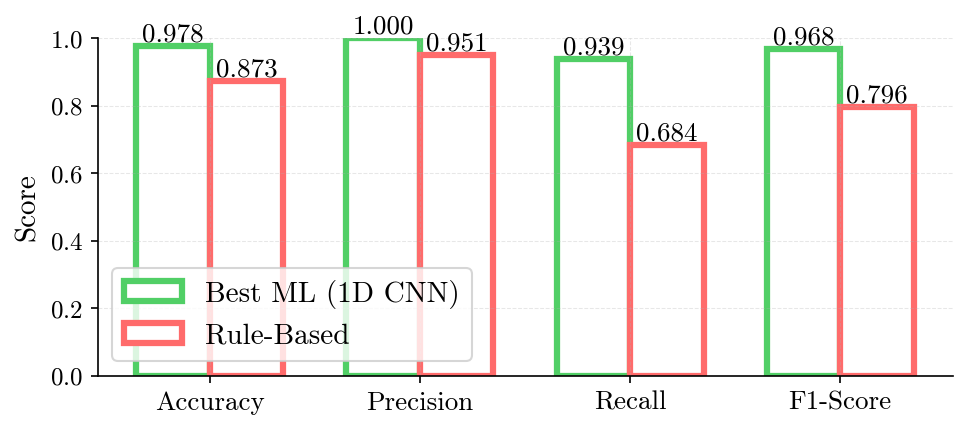

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set cmr10 globally (same style as training notebook)
plt.rcParams.update({
    'text.usetex': False,
    'axes.formatter.use_mathtext': True,
    'font.family': 'cmr10',
    'font.size': 16,
    'axes.labelsize': 14,
    'axes.titlesize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 150
})

# Create figure with subplots
fig = plt.figure(figsize=(15, 3))

# ========== LEFT SUBPLOT: Bar chart ==========
ax_bar = fig.add_axes([0.08, 0.15, 0.38, 0.75])

x_pos = np.arange(len(metrics))
width = 0.35

# Using red and green to match heatmaps
bars1 = ax_bar.bar(x_pos - width/2, ml_scores, width, label='Best ML (1D CNN)',
                   color='white', edgecolor='#51CF66', linewidth=3, alpha=1)  # Green edges
bars2 = ax_bar.bar(x_pos + width/2, rb_scores, width, label='Rule-Based',
                   color='white', edgecolor='#FF6B6B', linewidth=3, alpha=1)  # Red edges

ax_bar.set_ylabel('Score', fontsize=14)
ax_bar.set_xticks(x_pos)
ax_bar.set_xticklabels(metrics, fontsize=13)
ax_bar.set_ylim([0, 1])
ax_bar.legend(fontsize=14, frameon=True, fancybox=True, shadow=False, loc='lower left')
ax_bar.grid(True, alpha=0.3, linestyle='--')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax_bar.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=13)

for bar in bars2:
    height = bar.get_height()
    ax_bar.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=13)

# ========== RIGHT SUBPLOT: Confusion matrices ==========
# ML-Based confusion matrix
# ax1_cm = fig.add_axes([0.50, 0.28, 0.2, 0.5]) 

# sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Greens',
#             xticklabels=['Not Circuit', 'Circuit'],
#             yticklabels=['Not Circuit', 'Circuit'],
#             ax=ax1_cm, cbar=False)
# ax1_cm.set_xlabel('Predicted', fontsize=14)
# ax1_cm.set_ylabel('True', fontsize=14)
# ax1_cm.set_title('ML-Based', fontsize=16, fontweight='bold')

# # Rule-Based confusion matrix
# ax2_cm = fig.add_axes([0.725, 0.28, 0.2, 0.5])

# sns.heatmap(cm_rb, annot=True, fmt='d', cmap='Reds',
#             xticklabels=['Not Circuit', 'Circuit'],
#             yticklabels=['Not Circuit', 'Circuit'],
#             ax=ax2_cm, cbar=False)
# ax2_cm.set_xlabel('Predicted', fontsize=14)
# ax2_cm.set_ylabel('')
# ax2_cm.set_title('Rule-Based', fontsize=16, fontweight='bold')

# plt.show()

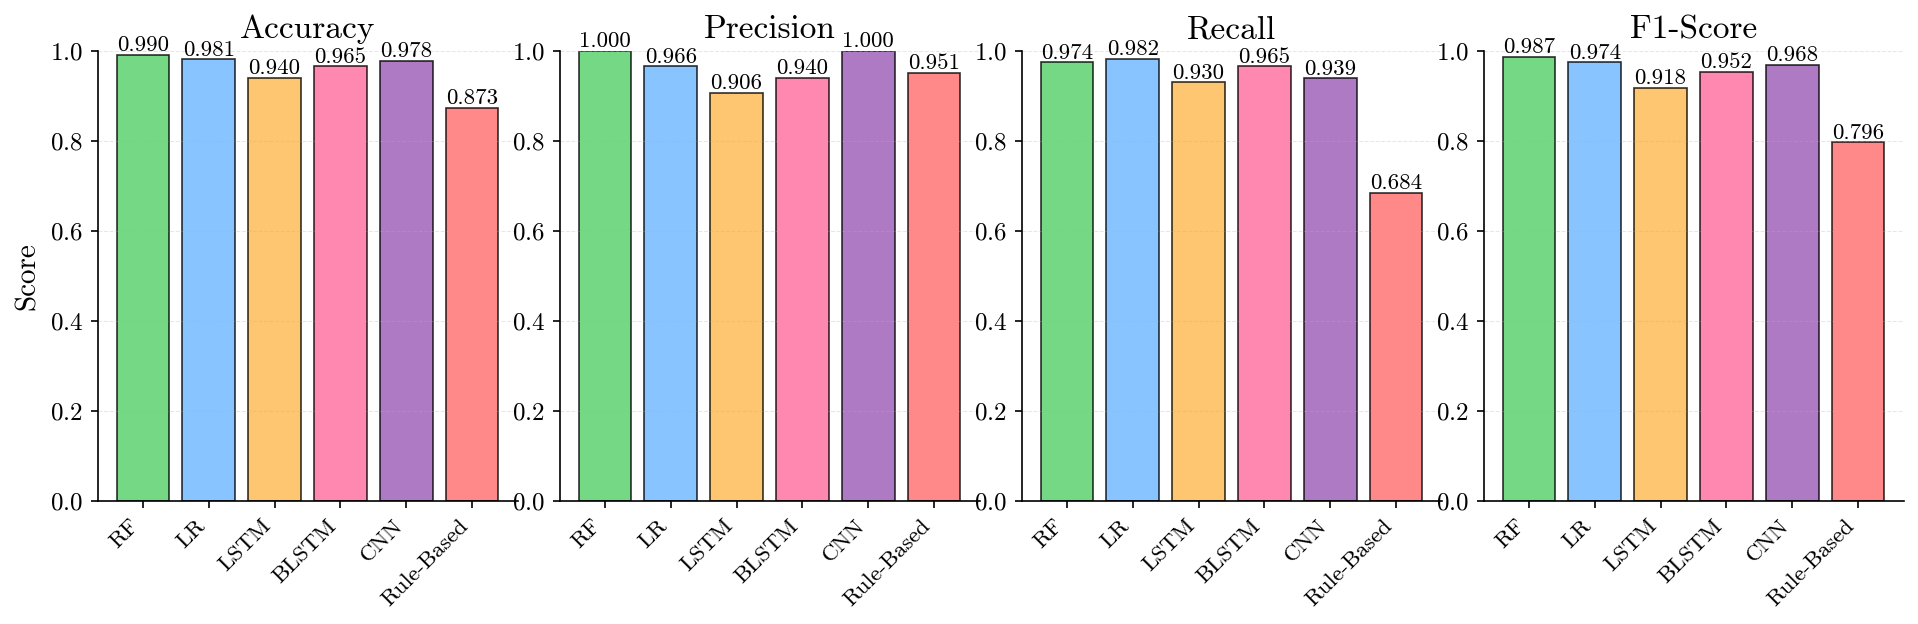


COMPREHENSIVE MODEL COMPARISON

Best performing model in each metric:
- Accuracy:  RF (0.990)
- Precision: RF (1.000)
- Recall:    LR (0.982)
- F1-Score:  RF (0.987)



In [23]:
# ========== COMPREHENSIVE MODEL COMPARISON: ALL ML MODELS vs RULE-BASED ==========
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set cmr10 globally (same style as training notebook)
plt.rcParams.update({
    'text.usetex': False,
    'axes.formatter.use_mathtext': True,
    'font.family': 'cmr10',
    'font.size': 16,
    'axes.labelsize': 14,
    'axes.titlesize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 150
})

# Calculate metrics for all ML models
all_model_scores = {}
model_names = ['rf', 'lr', 'lstm', 'blstm', 'cnn']

for model_name in model_names:
    df = model_results[model_name]
    y_true = df['gt_has_circuit'].astype(int)
    y_pred = df['ml_has_circuit'].astype(int)
    
    all_model_scores[model_name.upper()] = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Add rule-based scores
y_true_rb = rb_eval_df['gt_has_circuit'].astype(int)
y_pred_rb = rb_eval_df['rb_has_circuit'].astype(int)

all_model_scores['Rule-Based'] = {
    'Accuracy': accuracy_score(y_true_rb, y_pred_rb),
    'Precision': precision_score(y_true_rb, y_pred_rb, zero_division=0),
    'Recall': recall_score(y_true_rb, y_pred_rb),
    'F1-Score': f1_score(y_true_rb, y_pred_rb)
}

# Create DataFrame for easier plotting
comparison_df = pd.DataFrame(all_model_scores).T
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Create figure
fig = plt.figure(figsize=(14, 4))

# ========== LEFT SUBPLOT: Accuracy ==========
ax1 = fig.add_axes([0.06, 0.15, 0.20, 0.75])
x_pos = np.arange(len(comparison_df))
bars = ax1.bar(x_pos, comparison_df['Accuracy'], color=['#51CF66', '#6BB6FF', '#FFB84D', '#FF6B9D', '#9B59B6', '#FF6B6B'], 
               edgecolor='black', linewidth=0.8, alpha=0.8)
ax1.set_ylabel('Score', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df.index, fontsize=11, rotation=45, ha='right')
ax1.set_ylim([0, 1])
ax1.set_title('Accuracy', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--', axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
              f'{height:.3f}', ha='center', va='bottom', fontsize=11)

# ========== MIDDLE SUBPLOT: Precision ==========
ax2 = fig.add_axes([0.28, 0.15, 0.20, 0.75])
bars = ax2.bar(x_pos, comparison_df['Precision'], color=['#51CF66', '#6BB6FF', '#FFB84D', '#FF6B9D', '#9B59B6', '#FF6B6B'],
               edgecolor='black', linewidth=0.8, alpha=0.8)
# ax2.set_ylabel('Score', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df.index, fontsize=11, rotation=45, ha='right')
ax2.set_ylim([0, 1])
ax2.set_title('Precision', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
              f'{height:.3f}', ha='center', va='bottom', fontsize=11)

# ========== MIDDLE-RIGHT SUBPLOT: Recall ==========
ax3 = fig.add_axes([0.50, 0.15, 0.20, 0.75])
bars = ax3.bar(x_pos, comparison_df['Recall'], color=['#51CF66', '#6BB6FF', '#FFB84D', '#FF6B9D', '#9B59B6', '#FF6B6B'],
               edgecolor='black', linewidth=0.8, alpha=0.8)
# ax3.set_ylabel('Score', fontsize=14)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(comparison_df.index, fontsize=11, rotation=45, ha='right')
ax3.set_ylim([0, 1])
ax3.set_title('Recall', fontsize=16, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
              f'{height:.3f}', ha='center', va='bottom', fontsize=11)

# ========== RIGHT SUBPLOT: F1-Score ==========
ax4 = fig.add_axes([0.72, 0.15, 0.20, 0.75])
bars = ax4.bar(x_pos, comparison_df['F1-Score'], color=['#51CF66', '#6BB6FF', '#FFB84D', '#FF6B9D', '#9B59B6', '#FF6B6B'],
               edgecolor='black', linewidth=0.8, alpha=0.8)
# ax4.set_ylabel('Score', fontsize=14)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comparison_df.index, fontsize=11, rotation=45, ha='right')
ax4.set_ylim([0, 1])
ax4.set_title('F1-Score', fontsize=16, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
              f'{height:.3f}', ha='center', va='bottom', fontsize=11)

# plt.suptitle('Model Performance Comparison: All ML Models vs Rule-Based', 
#               fontsize=18, fontweight='bold', y=0.98)
plt.show()

# Print summary
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print("\nBest performing model in each metric:")
print("- Accuracy: ", comparison_df['Accuracy'].idxmax(), f"({comparison_df['Accuracy'].max():.3f})")
print("- Precision:", comparison_df['Precision'].idxmax(), f"({comparison_df['Precision'].max():.3f})")
print("- Recall:   ", comparison_df['Recall'].idxmax(), f"({comparison_df['Recall'].max():.3f})")
print("- F1-Score: ", comparison_df['F1-Score'].idxmax(), f"({comparison_df['F1-Score'].max():.3f})")
print("\n" + "="*80)


In [9]:
# Calculate metrics
eval_df = pd.DataFrame(evaluation_results)

y_true = eval_df['gt_has_circuit'].astype(int)
y_pred = eval_df['ml_has_circuit'].astype(int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

print("="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"\nTotal flights evaluated: {len(eval_df)}")
print(f"\nGround Truth:")
print(f"  Flights with circuits: {y_true.sum()}")
print(f"  Flights without circuits: {len(y_true) - y_true.sum()}")
print(f"\nML Predictions:")
print(f"  Flights with circuits detected: {y_pred.sum()}")
print(f"  Flights without circuits: {len(y_pred) - y_pred.sum()}")
print(f"\nConfusion Matrix:")
print(f"  True Negatives  (TN): {TN}")
print(f"  False Positives (FP): {FP}")
print(f"  False Negatives (FN): {FN}")
print(f"  True Positives  (TP): {TP}")
print(f"\nMetrics:")
print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.3f}")
print(f"  Precision: {precision_score(y_true, y_pred, zero_division=0):.3f}")
print(f"  Recall:    {recall_score(y_true, y_pred, zero_division=0):.3f}")
print(f"  F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.3f}")
print("="*60)

EVALUATION RESULTS

Total flights evaluated: 315

Ground Truth:
  Flights with circuits: 114
  Flights without circuits: 201

ML Predictions:
  Flights with circuits detected: 107
  Flights without circuits: 208

Confusion Matrix:
  True Negatives  (TN): 201
  False Positives (FP): 0
  False Negatives (FN): 7
  True Positives  (TP): 107

Metrics:
  Accuracy:  0.978
  Precision: 1.000
  Recall:    0.939
  F1 Score:  0.968


In [10]:
# Show false positives
false_positives = eval_df[(eval_df['gt_has_circuit'] == False) & (eval_df['ml_has_circuit'] == True)]
print(f"\nFalse Positives: {len(false_positives)}")
print(false_positives[['unique_flight_id', 'gt_n_circuits', 'ml_n_circuits']].head(10))


False Positives: 0
Empty DataFrame
Columns: [unique_flight_id, gt_n_circuits, ml_n_circuits]
Index: []


In [11]:
# Show false negatives
false_negatives = eval_df[(eval_df['gt_has_circuit'] == True) & (eval_df['ml_has_circuit'] == False)]
print(f"\nFalse Negatives: {len(false_negatives)}")
print(false_negatives[['unique_flight_id', 'gt_n_circuits', 'ml_n_circuits']].head(10))


False Negatives: 7
          unique_flight_id  gt_n_circuits  ml_n_circuits
112  HBKLA_20250719_114524              1              0
211  HBKOJ_20250103_091203              1              0
214  HBKOJ_20250115_101038              2              0
218  HBKOJ_20250117_123730              3              0
228  HBKOJ_20250219_130305              1              0
230  HBKOJ_20250226_124143              1              0
231  HBKOJ_20250227_130819              1              0


In [1]:
display( df_labeled[df_labeled.unique_flight_id == 'HBKOJ_20250103_091203'] )
flight = pickle.loads ( df_labeled[df_labeled.unique_flight_id == 'HBKOJ_20250103_091203'].flight_pickle.iloc[1] )

NameError: name 'df_labeled' is not defined

In [42]:
flight.map_leaflet(zoom=12)

c:\Users\fusg\Documents\Lommis_App\.venv\Lib\site-packages\traffic\core\flight.py:1408: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Map(center=[47.59693506058032, 8.918175247621328], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [43]:
_, _, ml_circuits, _ = lommis_func.find_aerodrome_circuits(
    flight,
    airport="LSZT",
    rwy='06',
    model='cnn',
    plot=True,
    debug=True,
    scale=1.5
)

Loaded CNN model (deep learning, requires phases + scaling)
FLIGHT SEGMENT 0 | Start Index : 1 | End Index : 1830 
FLIGHT SEGMENT 1 | Start Index : 1831 | End Index : 1970 
FLIGHT SEGMENT 2 | Start Index : 1971 | End Index : 2158 
INITIAL SEGMENT LENGTH 0 : 1829
INITIAL SEGMENT LENGTH 1 : 139
INITIAL SEGMENT LENGTH 2 : 187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


[0 0 0]
No airdrome circuit detected


In [24]:
# Load the parquet file
df = pd.read_parquet('EMERGENCY_SAVE.parquet')

# Check the current state
print("BEFORE:")
print(df[(df['unique_flight_id'] == 'HBSGT_20250410_114423')][['segment_num', 'label']])

# Update segments 0 and 1 to 'omitted'
mask = (df['unique_flight_id'] == 'HBSGT_20250410_114423') & (df['segment_num'].isin([0, 1]))
df.loc[mask, 'label'] = 'omitted'

# Verify the change
print("\nAFTER:")
print(df[(df['unique_flight_id'] == 'HBSGT_20250410_114423')][['segment_num', 'label']])

# Count distribution
print("\nOverall label distribution:")
print(df['label'].value_counts())

# Save back to parquet
df.to_parquet('EMERGENCY_SAVE.parquet', index=False)
print("\n✅ Saved to EMERGENCY_SAVE.parquet")

BEFORE:
      segment_num          label
2950            0  not_a_circuit
2951            1  not_a_circuit

AFTER:
      segment_num    label
2950            0  omitted
2951            1  omitted

Overall label distribution:
label
not_a_circuit      2422
traffic_circuit     695
omitted             180
Name: count, dtype: int64

✅ Saved to EMERGENCY_SAVE.parquet


In [12]:
# Save evaluation results
eval_df.to_csv('evaluation_results.csv', index=False)
print("\n✅ Saved evaluation results to evaluation_results.csv")


✅ Saved evaluation results to evaluation_results.csv
